In [ ]:
# !pip install langchain==0.0.171 openai==0.27.6 tabulate==0.9.0 timm==0.9.2 transformers==4.29.2

In [1]:
from langchain.tools import BaseTool
from transformers import BlipProcessor, BlipForConditionalGeneration, DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import torch
from IPython.display import display
from langchain.agents import initialize_agent
from langchain.chat_models import ChatOpenAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory


In [2]:
class ImageCaptionTool(BaseTool):
    name = "Image caption Generator"
    description = "Use this tool When describing a given image."\
                    "It will explain the image based on a caption it generated."
    def _run(self, img_path):
        image = Image.open(img_path).convert('RGB')
        model_name = "Salesforce/blip-image-captioning-large"
        device = "cpu"
        processor = BlipProcessor.from_pretrained(model_name)
        model = BlipForConditionalGeneration.from_pretrained(model_name).to(device)
        inputs = processor(image, return_tensors='pt').to(device)
        output = model.generate(**inputs, max_new_tokens=250)
        caption = processor.decode(output[0], skip_special_tokens=True)
        return caption
    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

In [3]:
class ObjectDetectionTool(BaseTool):
    name = "Object detection"
    description = "Use this tool to detect objects in an image provided to you."\
                  "It will return list of all detected objects in the list is format"\
                  "[x1, y1, x2, y2] class_name confidence_score."
    def _run(self, img_path):
        image = Image.open(img_path).convert('RGB')
        processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
        model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
        inputs = processor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        # convert outputs (bounding boxes and class logits) to COCO API
        # let's only keep detections with score > 0.9
        target_sizes = torch.tensor([image.size[::-1]])
        results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]
        detections = ""
        for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
            detections += '[{}, {}, {}, {}]'.format(int(box[0]), int(box[1]), int(box[2]), int(box[3]))
            detections += ' {}'.format(model.config.id2label[int(label)])
            detections += ' {}\n'.format(float(score))
        return detections
    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

In [12]:
tools = [ImageCaptionTool(), ObjectDetectionTool()]
conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5,
    return_messages=True
)

In [13]:
llm = ChatOpenAI(
    openai_api_key='*********************',
    temperature=0.5,
    model_name="gpt-3.5-turbo"
)

In [14]:
agent = initialize_agent(
    agent = "chat-conversational-react-description",
    tools = tools,
    llm = llm,
    verbose = True,
    memory = conversational_memory,
    early_stopping_method = 'generate'
)

Enter the path or URL of the image: /content/image.png


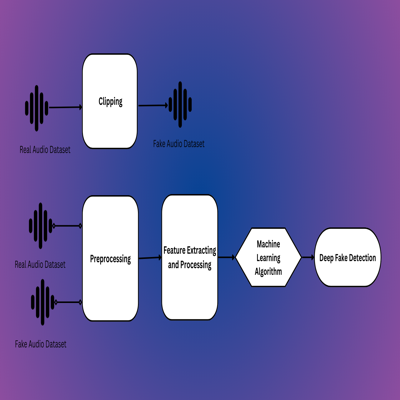

In [15]:
if __name__ == "__main__":
    image_path = input("Enter the path or URL of the image: ")
    image = Image.open(image_path).convert('RGB')
    new_size = (400, 400)
    resized_image = image.resize(new_size)
    display(resized_image)

In [18]:
user_input = input("Enter the question related to the image.")
response = agent.run('{}, this is the image path: {}'.format(user_input, image_path))

Enter the question related to the image.Explain the image


> Entering new AgentExecutor chain...
{
    "action": "Image caption Generator",
    "action_input": "/content/image.png"
}
Observation: a diagram of a process of recording a music recording
Thought:{
    "action": "Final Answer",
    "action_input": "The image is a diagram illustrating the process of recording a music recording."
}

> Finished chain.
